# Bidirectional LSTM Baseline


I wanted to check that training a sequence model without any linguistic pretraining can resolve the contextual ambiguity between the speech classes in the `HatexPlain Dataset`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from collections import Counter
import json
import pickle

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset

Used the same preprocessed dataset used in Tf-Idf baseline


In [5]:
train_df = pd.read_csv("../data/baseline/train_base.csv")
val_df = pd.read_csv("../data/baseline/val_base.csv")
test_df = pd.read_csv("../data/baseline/test_base.csv")
train_df.head()

,post_id,source,text,label
0,23107796_gab,gab,u really think would not raped feral hindu mus...,offensive
1,9995600_gab,gab,uk threatened return radioactive waste eu agre...,offensive
2,1227920812235051008_twitter,twitter,english not imposition hindi also not impositi...,offensive
3,1204931715778543624_twitter,twitter,no liberal congratulated hindu refugees post c...,offensive
4,1179102559241244672_twitter,twitter,said bro even texts sound redneck whatever fuc...,offensive


### Label Encoding the classes to numeric values to feed


In [6]:
lab_enco = LabelEncoder()

In [7]:
train_df["encoded_label"] = lab_enco.fit_transform(train_df["label"])
val_df["encoded_label"] = lab_enco.transform(val_df["label"])
test_df["encoded_label"] = lab_enco.transform(test_df["label"])

In [8]:
lab_enco.classes_

array(['hatespeech', 'normal', 'offensive'], dtype=object)

## Vocab building and encoding

- Vocab Construction from scratch
- Not used any external pretrained tokenizer
- Implemented sequence encoding and Padding


In [9]:
def vocab(texts, max_vocab=20000):
    cnt = Counter()
    for text in texts:
        cnt.update(text.split())
    most_common = cnt.most_common(max_vocab - 2)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for i, (word, _) in enumerate(most_common, start=2):
        vocab[word] = i
    return vocab

In [10]:
vocab = vocab(train_df["text"], max_vocab=20000)
len(vocab)

20000

In [ ]:
max_words = 100


def encode(text, vocab, max_len):
    tokens = text.split()
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens][:max_len]
    return ids + [0] * (max_len - len(ids))

In [ ]:
train_df["encoded"] = (
    train_df["text"].astype(str).apply(lambda x: encode(x, vocab, max_words))
)
val_df["encoded"] = (
    val_df["text"].astype(str).apply(lambda x: encode(x, vocab, max_words))
)
test_df["encoded"] = (
    test_df["text"].astype(str).apply(lambda x: encode(x, vocab, max_words))
)
train_df.sample(5)

,post_id,source,text,label,encoded_label,encoded
9870,22358829_gab,gab,revolution without guns good luck little faggo...,offensive,2,"[1762, 297, 713, 44, 1332, 120, 39, 466, 10591..."
3104,1075590925852794881_twitter,twitter,would call ice report illegal alien note phone...,offensive,2,"[16, 78, 1199, 699, 42, 597, 1434, 1093, 674, ..."
10167,1178970101204344832_twitter,twitter,niggers tryna set girl please make sure got jo...,offensive,2,"[25, 1223, 669, 146, 178, 47, 156, 45, 313, 58..."
13758,23838441_gab,gab,not rot moloch approved ghetto forums least an...,hatespeech,0,"[3, 4361, 10974, 11461, 18, 5223, 286, 419, 48..."
8169,13032712_gab,gab,feargodnotdeath nigger tried calling omg wtf w...,hatespeech,0,"[18557, 5, 639, 187, 691, 591, 201, 88, 134, 0..."


## Pytorch dataset loader class


In [ ]:
class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = df["encoded"].tolist()
        self.labels = df["encoded_label"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.texts[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.long),
        )

In [ ]:
train_ds = TextDataset(train_df)
val_ds = TextDataset(val_df)
test_ds = TextDataset(test_df)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

## BiLSTM model architecture

- It has randomly initialized embedding layer
- A bidirectional LSTM encoder
- A fully connected classification layer


In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dimen, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dimen, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dimen, hidden_dim, batch_first=True, bidirectional=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        mask = (x != 0).unsqueeze(-1)
        out = out * mask
        out = out.sum(dim=1) / mask.sum(dim=1)
        return self.fc(out)

In [ ]:
model = BiLSTM(
    vocab_size=len(vocab), embed_dimen=100, hidden_dim=128, num_classes=3
).to(device)
model

BiLSTM(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

### Model Training

- Used `CrossEntropyLoss` and `Adam Optimizer` to train the model
- Used Validation Set to monitor how model generalizes and overfits


In [ ]:
counts = Counter(train_df["encoded_label"])
total = sum(counts.values())
weights = [total / (3 * counts[i]) for i in range(3)]
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
def eval(model, loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())

    return preds, labels

In [ ]:
def val(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
    return total_loss / len(loader)

## Model training and observation of losses/epoch


In [ ]:
train_loss, val_loss = [], []
EPOCHS = 20
for epoch in range(EPOCHS):
    tloss = train(model, train_loader)
    vloss = val(model, val_loader)
    train_loss.append(tloss)
    val_loss.append(vloss)
    print(f"Epoch {epoch+1} | Train Loss: {tloss:.4f} | Val Loss: {vloss:.4f}")

100%|██████████| 241/241 [00:02<00:00, 91.79it/s] 


Epoch 1 | Train Loss: 0.9337 | Val Loss: 0.8445


100%|██████████| 241/241 [00:02<00:00, 105.40it/s]


Epoch 2 | Train Loss: 0.7910 | Val Loss: 0.8189


100%|██████████| 241/241 [00:02<00:00, 105.20it/s]


Epoch 3 | Train Loss: 0.6766 | Val Loss: 0.8666


100%|██████████| 241/241 [00:02<00:00, 106.31it/s]


Epoch 4 | Train Loss: 0.5475 | Val Loss: 0.8816


100%|██████████| 241/241 [00:02<00:00, 104.76it/s]


Epoch 5 | Train Loss: 0.4028 | Val Loss: 0.9839


100%|██████████| 241/241 [00:02<00:00, 109.18it/s]


Epoch 6 | Train Loss: 0.2598 | Val Loss: 1.2692


100%|██████████| 241/241 [00:02<00:00, 108.57it/s]


Epoch 7 | Train Loss: 0.1653 | Val Loss: 1.4917


100%|██████████| 241/241 [00:02<00:00, 109.54it/s]


Epoch 8 | Train Loss: 0.1018 | Val Loss: 1.7972


100%|██████████| 241/241 [00:02<00:00, 109.55it/s]


Epoch 9 | Train Loss: 0.0759 | Val Loss: 1.9384


100%|██████████| 241/241 [00:02<00:00, 109.57it/s]


Epoch 10 | Train Loss: 0.0446 | Val Loss: 2.3385


100%|██████████| 241/241 [00:02<00:00, 110.14it/s]


Epoch 11 | Train Loss: 0.0384 | Val Loss: 2.4118


100%|██████████| 241/241 [00:02<00:00, 111.74it/s]


Epoch 12 | Train Loss: 0.0231 | Val Loss: 2.8369


100%|██████████| 241/241 [00:02<00:00, 111.20it/s]


Epoch 13 | Train Loss: 0.0188 | Val Loss: 2.9754


100%|██████████| 241/241 [00:02<00:00, 107.87it/s]


Epoch 14 | Train Loss: 0.0248 | Val Loss: 3.0465


100%|██████████| 241/241 [00:02<00:00, 106.74it/s]


Epoch 15 | Train Loss: 0.0417 | Val Loss: 2.7542


100%|██████████| 241/241 [00:02<00:00, 105.62it/s]


Epoch 16 | Train Loss: 0.0283 | Val Loss: 2.8116


100%|██████████| 241/241 [00:02<00:00, 105.35it/s]


Epoch 17 | Train Loss: 0.0249 | Val Loss: 2.8322


100%|██████████| 241/241 [00:02<00:00, 107.67it/s]


Epoch 18 | Train Loss: 0.0122 | Val Loss: 3.0212


100%|██████████| 241/241 [00:02<00:00, 108.97it/s]


Epoch 19 | Train Loss: 0.0108 | Val Loss: 3.2863


100%|██████████| 241/241 [00:02<00:00, 107.63it/s]


Epoch 20 | Train Loss: 0.0065 | Val Loss: 3.3768


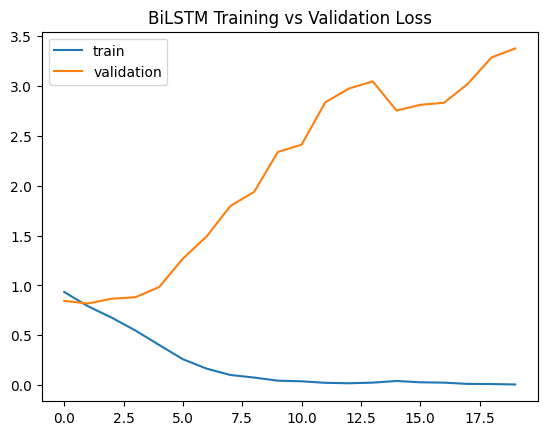

In [ ]:
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.legend()
plt.title("BiLSTM Training vs Validation Loss")
plt.savefig("../figures/bilstm_training_loss.png", dpi=300, bbox_inches="tight")
plt.show()

## Model Evaluation


- Evaluated the model on test set using `precision`, `recall`,`F1-Score` and `Confusion Matrix`


In [ ]:
y_pred, y_true = eval(model, test_loader)

class_repo = classification_report(
    y_true, y_pred, target_names=lab_enco.classes_, digits=4, output_dict=True
)
print(class_repo)

{'hatespeech': {'precision': 0.6650485436893204, 'recall': 0.6919191919191919, 'f1-score': 0.6782178217821783, 'support': 594.0}, 'normal': {'precision': 0.6626666666666666, 'recall': 0.6355498721227621, 'f1-score': 0.6488250652741514, 'support': 782.0}, 'offensive': {'precision': 0.4694244604316547, 'recall': 0.4762773722627737, 'f1-score': 0.47282608695652173, 'support': 548.0}, 'accuracy': 0.6075883575883576, 'macro avg': {'precision': 0.5990465569292139, 'recall': 0.601248812101576, 'f1-score': 0.5999563246709505, 'support': 1924.0}, 'weighted avg': {'precision': 0.6083621479216925, 'recall': 0.6075883575883576, 'f1-score': 0.6077709370245189, 'support': 1924.0}}


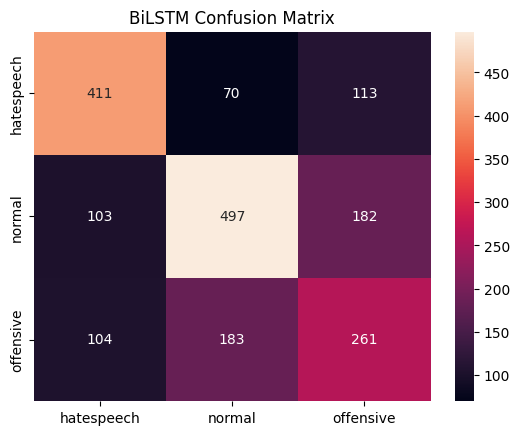

In [ ]:
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=lab_enco.classes_,
    yticklabels=lab_enco.classes_,
)
plt.title("BiLSTM Confusion Matrix")
plt.savefig("../figures/bilstm_conf_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

### Saved the Metrics for further analysis and model comparison.


In [ ]:
with open("../results/bilstm/metrics.json", "w") as f:
    json.dump(class_repo, f, indent=4)

In [ ]:
pd.DataFrame(cm, index=lab_enco.classes_, columns=lab_enco.classes_).to_csv(
    "../results/bilstm/confusion_matrix.csv"
)

In [ ]:
pred_df = test_df.copy()
pred_df["predicted_label"] = lab_enco.inverse_transform(y_pred)
pred_df.to_csv("../results/bilstm/predictions.csv", index=False)

## Error Analysis


In [ ]:
err_df = pred_df[pred_df["label"] != pred_df["predicted_label"]]
err_df

,post_id,source,text,label,encoded_label,encoded,predicted_label
1,1165785686903009283_twitter,twitter,USER missing essential premise whether immigra...,normal,1,"[2, 1553, 6625, 14155, 1578, 30, 2398, 851, 19...",offensive
4,1169443635869487105_twitter,twitter,USER lol not deal bms not outside children ss ...,offensive,2,"[2, 54, 3, 483, 1, 3, 887, 103, 4648, 365, 18,...",normal
6,1168407844095483904_twitter,twitter,yeah humnh use app alittle retarded ogre,offensive,2,"[150, 1, 149, 2080, 19232, 19, 2818, 0, 0, 0, ...",hatespeech
8,24305062_gab,gab,education marxist indoctrination since well es...,hatespeech,0,"[1617, 1151, 4895, 157, 72, 3243, 76, 4918, 33...",offensive
10,1178857682511511552_twitter,twitter,pussy hoe could never ghetto hate hearing,normal,1,"[408, 158, 91, 48, 18, 23, 1814, 0, 0, 0, 0, 0...",offensive
...,...,...,...,...,...,...,...
1917,1238155848066764800_twitter,twitter,ghetto genius slap shit knowledge,offensive,2,"[18, 2666, 1802, 21, 2777, 0, 0, 0, 0, 0, 0, 0...",normal
1918,1272930487011627010_twitter,twitter,fucking hate wokeoids bro legit subhuman degens,offensive,2,"[17, 23, 1, 364, 3283, 2134, 1, 0, 0, 0, 0, 0,...",normal
1919,7645213_gab,gab,hate islam mock paedophile prophet mohammed mu...,hatespeech,0,"[23, 63, 7154, 4284, 2499, 2051, 81, 29, 8, 19...",offensive
1920,7672117_gab,gab,sounds like clothing line start line robes cal...,offensive,2,"[508, 6, 5374, 572, 213, 572, 12109, 99, 1521,...",hatespeech


In [ ]:
err_df.sample(200, random_state=42).to_csv(
    "../results/bilstm/error_sample.csv", index=False
)

In [ ]:
torch.save(model.state_dict(), "../models/bilstm/bilstm_model.pt")

In [ ]:
with open("../models/bilstm/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

In [ ]:
err_df.shape

(755, 7)

In [ ]:
hate_as_off = err_df[
    (err_df.label == "hatespeech") & (err_df.predicted_label == "offensive")
]
off_as_hate = err_df[
    (err_df.label == "offensive") & (err_df.predicted_label == "hatespeech")
]
norm_as_off = err_df[
    (err_df.label == "normal") & (err_df.predicted_label == "offensive")
]

In [ ]:
hate_as_off.sample(5, random_state=1)[["text", "label", "predicted_label"]]

,text,label,predicted_label
1600,barely go society anymore basically buy food b...,hatespeech,offensive
770,iran women children raped murdered stabbed inv...,hatespeech,offensive
1042,honestly woman would not ever date solid black...,hatespeech,offensive
1440,democrats forever partyofslaves ever obstruct ...,hatespeech,offensive
1223,edgy gg stans think racist ok hate faggots,hatespeech,offensive


In [ ]:
off_as_hate.sample(5, random_state=2)[["text", "label", "predicted_label"]]

,text,label,predicted_label
1491,laughed disrespected peers stop talking couple...,offensive,hatespeech
731,fucking hate bro stg skull skull skull skull,offensive,hatespeech
1103,niggers tulsa video saying fuck police wild ni...,offensive,hatespeech
675,gym muscle faggots not spend time rushing homo...,offensive,hatespeech
396,fems outchere fucking dykes need half rent,offensive,hatespeech


In [ ]:
norm_as_off.sample(5, random_state=3)[["text", "label", "predicted_label"]]

,text,label,predicted_label
186,fight white apologists white not terrorized an...,normal,offensive
24,pac said mfs fuck fuck u die slow mfs make sur...,normal,offensive
869,nasa missed perfect chance send man women moon...,normal,offensive
1894,old white people really think entitled wow not...,normal,offensive
1594,bigger hoops bigger hoe guy gas station,normal,offensive


# Takeaway:


- It shows strong memorization of the dataset
- The rapid gain of validation loss shows that it is not able to transfer the learned representation of training dataset on validation dataset
- I think model is not limited due to it's architecture or optimization but due to the linguistic knowledge absence.
- So i think `pretrained linguistic tokenization and transfer learning` will help it generalize well
